# ECCO Data - cleaned version
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [2]:
from dask.distributed import Client

client = Client("tcp://10.32.16.46:33169")
client

Client Scheduler: tcp://10.32.16.46:33169 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 25 Cores: 50 Memory: 287.50 GB


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [4]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [5]:
ds_ll = faces_dataset_to_latlon(ds)

In [6]:
# a trick to make things work a bit faster
coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
coords = coords_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])
ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [8]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row

In [9]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

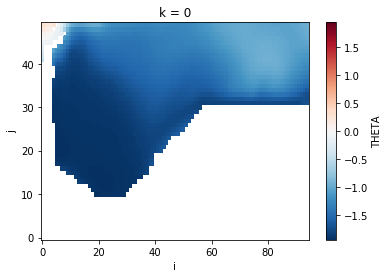

In [10]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [11]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

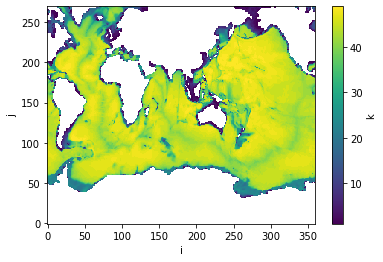

In [12]:
depth_max.plot()

In [13]:
bottom_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4'))
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range)

In [14]:
bottom_temp_wg.load()

<xarray.DataArray 'THETA' (time: 288, j: 50, i: 95)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.46867728,  1.7959569 ,  1.7288482 , ..., -0.63816595,
         -0.6382606 , -0.6382265 ],
        [-0.05218363,  0.13044833,  1.811099  , ..., -0.6396008 ,
         -0.63945144, -0.6392597 ],
        [-0.05472618, -0.10532754,  0.062052  , ..., -0.64123577,
         -0.64078325, -0.64044195]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.46877903,  1.7960036 ,  1.7371451 , ..., -0.6377463 ,
         -0.6378757 , -0.6376736 ],
        [-0.0668128 ,  0.1236141 ,  1.8105663 , ..., -0.63907963,
         -0.6389995 , -0.6386829 ],
        [-0.06605929, -0.11138503,  0.0565573 , ..., -0.64058465,
         -0.64025545, -0.6398734 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.47022742,  1.7935413 ,  1.7171884 , ..., -0.63722324,
         -0.6374599 , -0.6374008 ],
        [-0.06729086,  0.12015765,  1.8106636 , ..., -0.63852054,
         -0.6385272 , -0.63833755],
        [-0.06539927, -0.1154009 ,  0.05168646, ..., -0.6400233 ,
         -0.63975984, -0.6394815 ]],

       ...,

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.69571173,  1.8895117 ,  1.8237844 , ..., -0.574106  ,
         -0.5747176 , -0.57515246],
        [ 0.3109029 ,  0.39383444,  1.8925959 , ..., -0.5746678 ,
         -0.5751495 , -0.57549167],
        [ 0.3038472 ,  0.26501435,  0.35679856, ..., -0.57507133,
         -0.57543147, -0.5757563 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.6944544 ,  1.8897102 ,  1.8287387 , ..., -0.57349426,
         -0.57428366, -0.5748251 ],
        [ 0.30844426,  0.3906638 ,  1.8923483 , ..., -0.5740669 ,
         -0.57464576, -0.5751689 ],
        [ 0.29951465,  0.26471093,  0.35378653, ..., -0.5745686 ,
         -0.5749115 , -0.5754153 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.6921614 ,  1.8880028 ,  1.8286233 , ..., -0.5732399 ,
         -0.5739944 , -0.5745553 ],
        [ 0.30468023,  0.38868093,  1.8914307 , ..., -0.57375324,
         -0.57429785, -0.57485354],
        [ 0.29538646,  0.26396686,  0.35274544, ..., -0.57418454,
         -0.5744802 , -0.57504123]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 201

In [15]:
bottom_temp_wg_mean = bottom_temp_wg.mean(dim='time').load()

In [16]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [17]:
bottom_temp_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_temp_wg_mean

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

In [18]:
lon = coords_before_drop.XC.isel(**lon_range, **lat_range)
lat = coords_before_drop.YC.isel(**lat_range, **lon_range)

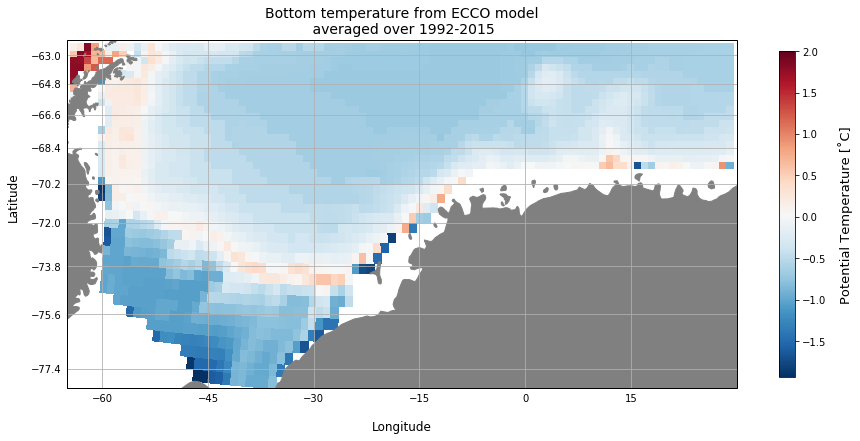

In [19]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from ECCO model\n averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [20]:
bottom_std_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_temp_wg = bottom_std_temp.isel(**lat_range, **lon_range)

In [21]:
bottom_std_temp_wg.load()

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07491323, 0.03105013, 0.08613247, ..., 0.02001635, 0.01984921,
        0.01967735],
       [0.10633206, 0.08333268, 0.0289332 , ..., 0.02005466, 0.01991507,
        0.01977147],
       [0.10318091, 0.11221348, 0.09422934, ..., 0.02019693, 0.02006324,
        0.0199395 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
Dimensions without coordinates: j, i

In [22]:
bottom_std_temp_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_std_temp_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_std_temp_wg

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07491323, 0.03105013, 0.08613247, ..., 0.02001635, 0.01984921,
        0.01967735],
       [0.10633206, 0.08333268, 0.0289332 , ..., 0.02005466, 0.01991507,
        0.01977147],
       [0.10318091, 0.11221348, 0.09422934, ..., 0.02019693, 0.02006324,
        0.0199395 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

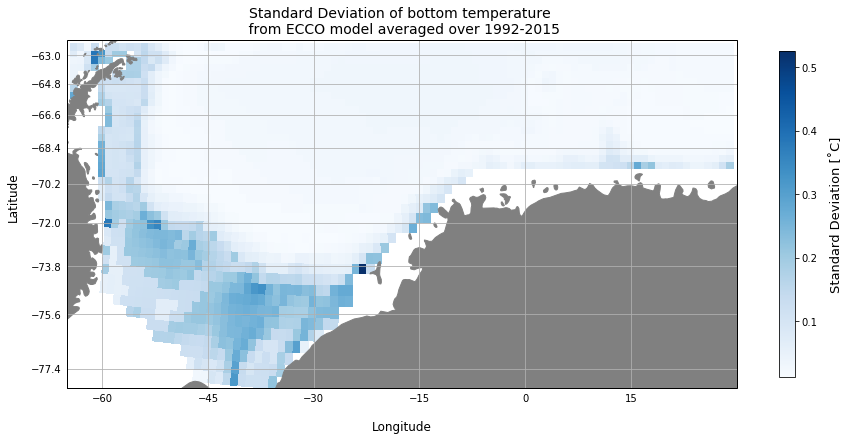

In [36]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_temp_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='Blues')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from ECCO model averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Temperature Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)

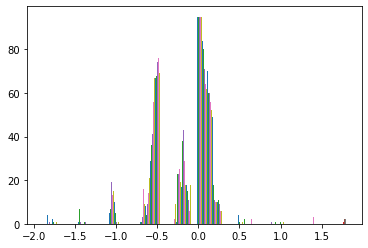

In [25]:
plt.hist(bottom_temp_wg_mean); #different temp bins have normal/skewed distribution

In [26]:
from scipy import stats

In [27]:
zscore_temp = stats.zscore(bottom_temp_wg, axis=0)

/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


## By hand

In [29]:
bottom_temp_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_temp_wg

<xarray.DataArray 'THETA' (time: 288, j: 50, i: 95)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.46867728,  1.7959569 ,  1.7288482 , ..., -0.63816595,
         -0.6382606 , -0.6382265 ],
        [-0.05218363,  0.13044833,  1.811099  , ..., -0.6396008 ,
         -0.63945144, -0.6392597 ],
        [-0.05472618, -0.10532754,  0.062052  , ..., -0.64123577,
         -0.64078325, -0.64044195]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.46877903,  1.7960036 ,  1.7371451 , ..., -0.6377463 ,
         -0.6378757 , -0.6376736 ],
        [-0.0668128 ,  0.1236141 ,  1.8105663 , ..., -0.63907963,
         -0.6389995 , -0.6386829 ],
        [-0.06605929, -0.11138503,  0.0565573 , ..., -0.64058465,
         -0.64025545, -0.6398734 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.47022742,  1.7935413 ,  1.7171884 , ..., -0.63722324,
         -0.6374599 , -0.6374008 ],
        [-0.06729086,  0.12015765,  1.8106636 , ..., -0.63852054,
         -0.6385272 , -0.63833755],
        [-0.06539927, -0.1154009 ,  0.05168646, ..., -0.6400233 ,
         -0.63975984, -0.6394815 ]],

       ...,

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.69571173,  1.8895117 ,  1.8237844 , ..., -0.574106  ,
         -0.5747176 , -0.57515246],
        [ 0.3109029 ,  0.39383444,  1.8925959 , ..., -0.5746678 ,
         -0.5751495 , -0.57549167],
        [ 0.3038472 ,  0.26501435,  0.35679856, ..., -0.57507133,
         -0.57543147, -0.5757563 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.6944544 ,  1.8897102 ,  1.8287387 , ..., -0.57349426,
         -0.57428366, -0.5748251 ],
        [ 0.30844426,  0.3906638 ,  1.8923483 , ..., -0.5740669 ,
         -0.57464576, -0.5751689 ],
        [ 0.29951465,  0.26471093,  0.35378653, ..., -0.5745686 ,
         -0.5749115 , -0.5754153 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.6921614 ,  1.8880028 ,  1.8286233 , ..., -0.5732399 ,
         -0.5739944 , -0.5745553 ],
        [ 0.30468023,  0.38868093,  1.8914307 , ..., -0.57375324,
         -0.57429785, -0.57485354],
        [ 0.29538646,  0.26396686,  0.35274544, ..., -0.57418454,
         -0.5744802 , -0.57504123]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 201

In [30]:
bottom_temp_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)

In [31]:
#manually calculated z-score
zscore_hand = (bottom_temp_wg - bottom_temp_wg_mean) / bottom_std_temp_wg
zscore_hand

<xarray.DataArray 'THETA' (time: 288, j: 50, i: 95)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.293945  , -1.0676155 ,  0.5557806 , ..., -1.5336524 ,
         -1.5518426 , -1.5634729 ],
        [-1.7209054 , -1.4462093 , -0.99972695, ..., -1.543868  ,
         -1.5633901 , -1.570582  ],
        [-1.7379473 , -1.6499981 , -1.449431  , ..., -1.5383432 ,
         -1.565228  , -1.570556  ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.2925868 , -1.0661105 ,  0.65210724, ..., -1.5126858 ,
         -1.5324501 , -1.5353749 ],
        [-1.8584855 , -1.5282205 , -1.01814   , ..., -1.5178798 ,
         -1.5406977 , -1.5414089 ],
        [-1.8477848 , -1.70398   , -1.507743  , ..., -1.5061046 ,
         -1.5389212 , -1.5420414 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.2732525 , -1.1454103 ,  0.42040935, ..., -1.4865556 ,
         -1.511502  , -1.5215107 ],
        [-1.8629813 , -1.5696982 , -1.0147779 , ..., -1.4900016 ,
         -1.5169816 , -1.5239419 ],
        [-1.8413881 , -1.7397677 , -1.5594343 , ..., -1.4783105 ,
         -1.5142187 , -1.5223869 ]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.7366871 ,  1.9454106 ,  1.6579914 , ...,  1.6667302 ,
          1.649445  ,  1.6419417 ],
        [ 1.6937424 ,  1.7144489 ,  1.8169969 , ...,  1.6939328 ,
          1.6654196 ,  1.6546735 ],
        [ 1.7372437 ,  1.650335  ,  1.678539  , ...,  1.7376212 ,
          1.692062  ,  1.6735396 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.7199029 ,  1.951803  ,  1.7155113 , ...,  1.6972914 ,
          1.6713059 ,  1.6585774 ],
        [ 1.6706202 ,  1.6764009 ,  1.8084394 , ...,  1.7238976 ,
          1.6907129 ,  1.670998  ],
        [ 1.6952538 ,  1.647631  ,  1.6465741 , ...,  1.7625114 ,
          1.7179796 ,  1.6906413 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.6892942 ,  1.8968134 ,  1.7141716 , ...,  1.7099977 ,
          1.6858789 ,  1.6722902 ],
        [ 1.6352214 ,  1.6526064 ,  1.7767266 , ...,  1.7395368 ,
          1.7081827 ,  1.6869487 ],
        [ 1.6552446 ,  1.6410002 ,  1.6355258 , ...,  1.7815287 ,
          1.7394766 ,  1.709402  ]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 201

In [34]:
zscore_hand_mean = zscore_hand.mean(dim='time')

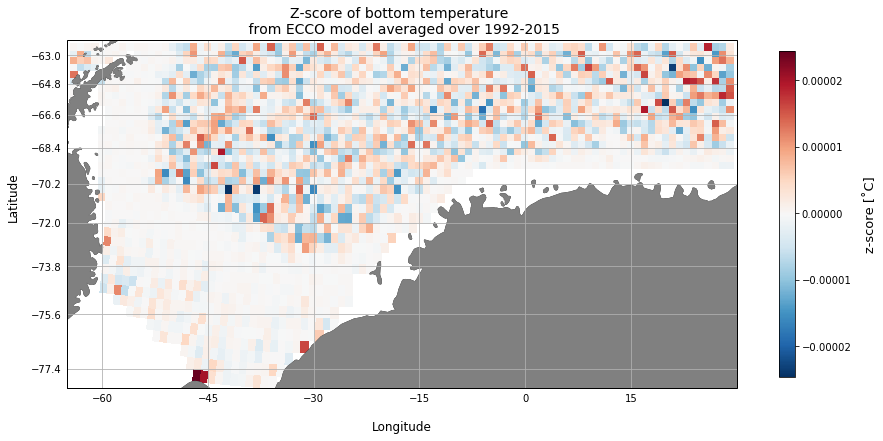

In [60]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, zscore_hand_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("z-score [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Z-score of bottom temperature \n from ECCO model averaged over 1992-2015', fontsize=14);

<span style='color:Green'> The highest Z-score value is 2e-5 which is 0.5 on the z-score table. So p>0.05 which means we can retain the null hypothesis (i.e. we can retain our assumption that the temperature distribution in the region is normal and carry on with our statistical anyalysis (standard deviation).

## Shapiro-Wilk Test
Normality test: tests if `ds` is of normal distribution. If data is normally distributed then datapoints are independent of one another...right?

In [52]:
bottom_temp_wg.size

1368000

In [53]:
stats.shapiro(bottom_temp_wg)

/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.8434714078903198, 0.0)

In [55]:
print(stats.shapiro(bottom_temp_wg), 
      ": p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000")

(0.8434714078903198, 0.0) : p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000


/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## <span style='color:Red'> Bottom Temperature Z-score (end)

## Bottom Salinity

In [37]:
bottom_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4'))

In [38]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range)

In [39]:
bottom_slt_wg.load()

<xarray.DataArray 'SALT' (time: 288, j: 50, i: 95)>
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.708115, 34.682255, 34.660656, ..., 34.660717, 34.6605  ,
         34.660297],
        [34.701786, 34.704594, 34.6808  , ..., 34.66061 , 34.660397,
         34.6602  ],
        [34.701675, 34.700718, 34.703335, ..., 34.660534, 34.66032 ,
         34.66012 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.70819 , 34.682068, 34.66499 , ..., 34.66071 , 34.660492,
         34.660275],
        [34.70147 , 34.704384, 34.68081 , ..., 34.660618, 34.6604  ,
         34.660187],
        [34.701355, 34.700485, 34.70313 , ..., 34.660545, 34.660328,
         34.66012 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.708263, 34.68018 , 34.658672, ..., 34.660698, 34.660477,
         34.66026 ],
        [34.70134 , 34.704243, 34.679356, ..., 34.660618, 34.6604  ,
         34.660183],
        [34.70125 , 34.700294, 34.70295 , ..., 34.660553, 34.660336,
         34.660122]],

       ...,

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716988, 34.68081 , 34.66339 , ..., 34.678368, 34.677933,
         34.67748 ],
        [34.708282, 34.710587, 34.6728  , ..., 34.678307, 34.677837,
         34.677353],
        [34.70816 , 34.706566, 34.70935 , ..., 34.67828 , 34.67779 ,
         34.677277]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716976, 34.68437 , 34.66841 , ..., 34.67846 , 34.67804 ,
         34.677597],
        [34.70827 , 34.710537, 34.675945, ..., 34.678413, 34.677963,
         34.677498],
        [34.70809 , 34.706623, 34.70929 , ..., 34.6784  , 34.67792 ,
         34.67744 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716938, 34.686474, 34.671482, ..., 34.67844 , 34.678024,
         34.677578],
        [34.7082  , 34.710506, 34.67907 , ..., 34.67842 , 34.677975,
         34.67752 ],
        [34.707985, 34.70662 , 34.709286, ..., 34.678436, 34.67797 ,
         34.6775  ]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [40]:
bottom_slt_wg_mean = bottom_slt_wg.mean(dim='time').load()

In [41]:
bottom_slt_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_slt_wg_mean

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.712536, 34.676   , 34.642563, ..., 34.6691  , 34.668694,
        34.66834 ],
       [34.702305, 34.706024, 34.67171 , ..., 34.669205, 34.668774,
        34.66839 ],
       [34.702038, 34.700333, 34.704147, ..., 34.66935 , 34.668922,
        34.668484]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

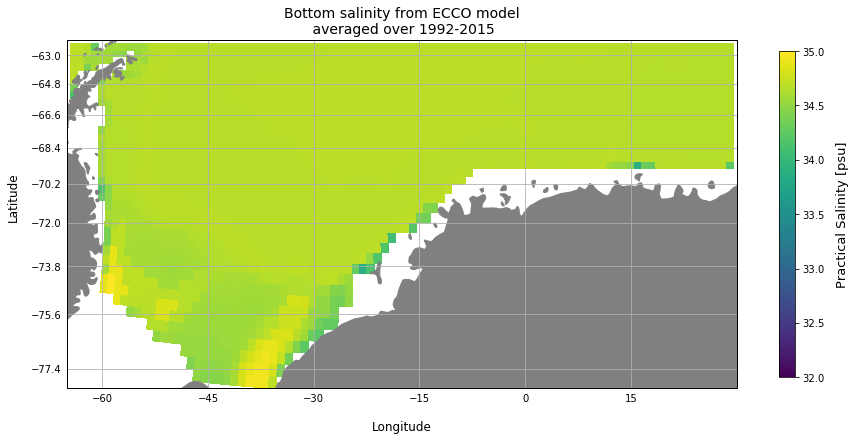

In [42]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='viridis', vmin=32, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [43]:
bottom_std_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_slt_wg = bottom_std_slt.isel(**lat_range, **lon_range)

In [44]:
bottom_std_slt_wg.load()

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00273975, 0.00564287, 0.01474723, ..., 0.00557772, 0.00552944,
        0.00547744],
       [0.00240092, 0.0022759 , 0.00506051, ..., 0.00562872, 0.0055671 ,
        0.00550446],
       [0.00243282, 0.00255845, 0.00248424, ..., 0.00568517, 0.00561054,
        0.00553797]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
Dimensions without coordinates: j, i

In [45]:
bottom_std_slt_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_std_slt_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_std_slt_wg

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00273975, 0.00564287, 0.01474723, ..., 0.00557772, 0.00552944,
        0.00547744],
       [0.00240092, 0.0022759 , 0.00506051, ..., 0.00562872, 0.0055671 ,
        0.00550446],
       [0.00243282, 0.00255845, 0.00248424, ..., 0.00568517, 0.00561054,
        0.00553797]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67

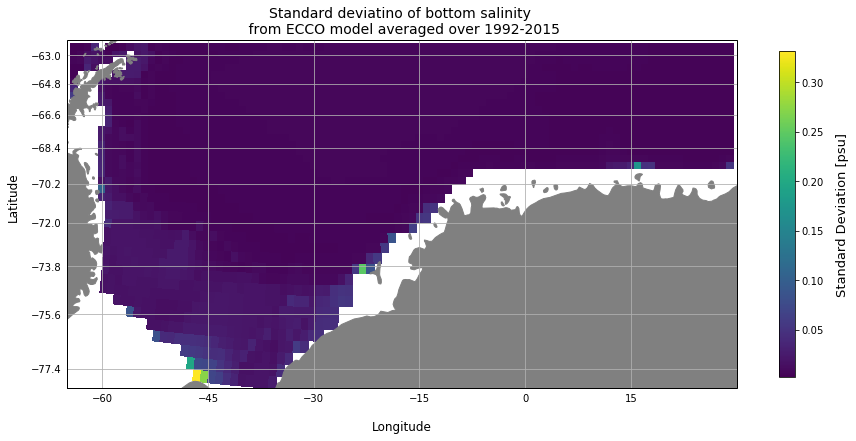

In [46]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_slt_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='viridis')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviatino of bottom salinity \n from ECCO model averaged over 1992-2015', fontsize=14);

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)

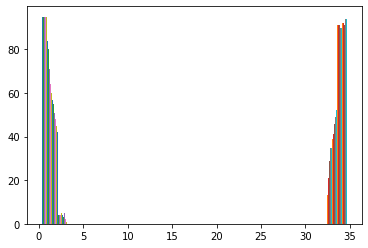

In [47]:
plt.hist(bottom_slt_wg_mean); #different temp bins have normal/skewed distribution

In [49]:
zscore_slt = stats.zscore(bottom_slt_wg, axis=0)

/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


## By hand

In [51]:
bottom_slt_wg['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg['i'] = coords_before_drop.i.isel(**lon_range)
bottom_slt_wg

<xarray.DataArray 'SALT' (time: 288, j: 50, i: 95)>
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.708115, 34.682255, 34.660656, ..., 34.660717, 34.6605  ,
         34.660297],
        [34.701786, 34.704594, 34.6808  , ..., 34.66061 , 34.660397,
         34.6602  ],
        [34.701675, 34.700718, 34.703335, ..., 34.660534, 34.66032 ,
         34.66012 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.70819 , 34.682068, 34.66499 , ..., 34.66071 , 34.660492,
         34.660275],
        [34.70147 , 34.704384, 34.68081 , ..., 34.660618, 34.6604  ,
         34.660187],
        [34.701355, 34.700485, 34.70313 , ..., 34.660545, 34.660328,
         34.66012 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.708263, 34.68018 , 34.658672, ..., 34.660698, 34.660477,
         34.66026 ],
        [34.70134 , 34.704243, 34.679356, ..., 34.660618, 34.6604  ,
         34.660183],
        [34.70125 , 34.700294, 34.70295 , ..., 34.660553, 34.660336,
         34.660122]],

       ...,

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716988, 34.68081 , 34.66339 , ..., 34.678368, 34.677933,
         34.67748 ],
        [34.708282, 34.710587, 34.6728  , ..., 34.678307, 34.677837,
         34.677353],
        [34.70816 , 34.706566, 34.70935 , ..., 34.67828 , 34.67779 ,
         34.677277]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716976, 34.68437 , 34.66841 , ..., 34.67846 , 34.67804 ,
         34.677597],
        [34.70827 , 34.710537, 34.675945, ..., 34.678413, 34.677963,
         34.677498],
        [34.70809 , 34.706623, 34.70929 , ..., 34.6784  , 34.67792 ,
         34.67744 ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [34.716938, 34.686474, 34.671482, ..., 34.67844 , 34.678024,
         34.677578],
        [34.7082  , 34.710506, 34.67907 , ..., 34.67842 , 34.677975,
         34.67752 ],
        [34.707985, 34.70662 , 34.709286, ..., 34.678436, 34.67797 ,
         34.6775  ]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [52]:
bottom_slt_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)

In [53]:
#manually calculated z-score
zscore_hand_slt = (bottom_slt_wg - bottom_slt_wg_mean) / bottom_std_slt_wg
zscore_hand_slt

<xarray.DataArray 'SALT' (time: 288, j: 50, i: 95)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.613736  ,  1.1086738 ,  1.2268816 , ..., -1.5032489 ,
         -1.4818808 , -1.4680917 ],
        [-0.21608315, -0.628547  ,  1.796347  , ..., -1.5269027 ,
         -1.5047463 , -1.4879137 ],
        [-0.14896126,  0.15059292, -0.32707375, ..., -1.5506594 ,
         -1.5332115 , -1.5105942 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.585889  ,  1.0755488 ,  1.5207331 , ..., -1.5046167 ,
         -1.4832606 , -1.4722704 ],
        [-0.34795743, -0.72073394,  1.7978547 , ..., -1.5255471 ,
         -1.5040611 , -1.4899929 ],
        [-0.28067437,  0.05964076, -0.40999386, ..., -1.5486465 ,
         -1.5318516 , -1.5105942 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.5594343 ,  0.7409186 ,  1.0923722 , ..., -1.5066684 ,
         -1.4860202 , -1.4750562 ],
        [-0.40197822, -0.78275055,  1.5106503 , ..., -1.5255471 ,
         -1.5040611 , -1.4906858 ],
        [-0.32457876, -0.01491019, -0.48216507, ..., -1.5473044 ,
         -1.5304918 , -1.5099053 ]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.6248748 ,  0.852462  ,  1.4123495 , ...,  1.6612337 ,
          1.6709104 ,  1.668666  ],
        [ 2.4897227 ,  2.004646  ,  0.21483798, ...,  1.6170393 ,
          1.6280862 ,  1.6285968 ],
        [ 2.5166614 ,  2.436325  ,  2.0945005 , ...,  1.5707891 ,
          1.5808057 ,  1.5877427 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.6206977 ,  1.4831892 ,  1.752762  , ...,  1.6776477 ,
          1.6902272 ,  1.6902555 ],
        [ 2.4849563 ,  1.9828564 ,  0.8367374 , ...,  1.6360155 ,
          1.6506985 ,  1.6549315 ],
        [ 2.4884372 ,  2.4586904 ,  2.0699315 , ...,  1.5915898 ,
          1.6039228 ,  1.6173621 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 1.6067742 ,  1.8563526 ,  1.9609929 , ...,  1.6742281 ,
          1.6874677 ,  1.6867733 ],
        [ 2.4547682 ,  1.9694474 ,  1.454114  , ...,  1.637371  ,
          1.6527542 ,  1.6590897 ],
        [ 2.4445326 ,  2.4571993 ,  2.068396  , ...,  1.5982997 ,
          1.6127617 ,  1.6283834 ]]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015

In [54]:
zscore_hand_slt_mean = zscore_hand_slt.mean(dim='time')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


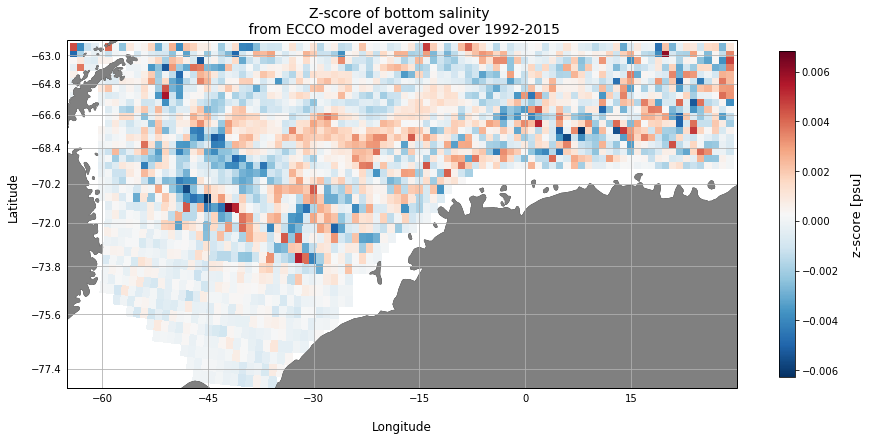

In [56]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, zscore_hand_slt_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("z-score [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Z-score of bottom salinity \n from ECCO model averaged over 1992-2015', fontsize=14);

<span style='color:Green'> The highest Z-score value is 2e-5 which is 0.5 on the z-score table. So p>0.05 which means we can retain the null hypothesis (i.e. we can retain our assumption that the temperature distribution in the region is normal and carry on with our statistical anyalysis (standard deviation).

## Shapiro-Wilk Test
Normality test: tests if `ds` is of normal distribution. If data is normally distributed then datapoints are independent of one another...right?

In [57]:
bottom_slt_wg.size

1368000

In [58]:
stats.shapiro(bottom_slt_wg)

/srv/conda/envs/notebook/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.634412407875061, 0.0)

In [59]:
print(stats.shapiro(bottom_slt_wg), 
      ": p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000")

(0.634412407875061, 0.0) : p < 0.05 so bottom wg mean temp dataset is NOT normally distributed? But Shapiro p value less reliable for N>5000


## <span style='color:Red'> Bottom Salinity Z-score (end)